In [43]:
import numpy as np
import os
import pywren_ibm_cloud as pywren
import pickle
import matplotlib.pyplot as plt
import pika
import montecarlo
%matplotlib notebook

In [44]:
n_functs = 1000
loop_per_funct = 10000
iter_send_point = 50
points_sent_len = 100
n_maps = 2
rabbitmq_url = '<AMQP_URL>'
rabbitmq_queue = 'pi_montecarlo'

In [45]:
def pi_montecarlo(n, rabbitmq):
    channel = rabbitmq.channel()
    channel.queue_declare(queue=rabbitmq_queue, auto_delete=True)
    
    l = list()
    value = 0
    sent = False
    funct_status = (n % iter_send_point == 0)
    for i in range(loop_per_funct):
        x = np.random.rand() # Generate random point between 0 and 1
        y = np.random.rand()
        z = np.sqrt(x * x + y * y)
        if z <= 1: # Point is inside circle
            value += 1
        if funct_status:
            l.append((x, y, z))
        if (not sent and funct_status and len(l) == points_sent_len): # Send generated point
            sent = True
            body = pickle.dumps(l)
            channel.basic_publish(exchange='', routing_key='pi_montecarlo', body=body)
            
    est_pi = float(value) * 4 / loop_per_funct
    return est_pi

def mean(results):
    return np.mean(results)

In [46]:
pwex = pywren.ibm_cf_executor(runtime_memory=256, rabbitmq_monitor=True)
map_iterdata=range(n_functs)
futures = list()
for i in range(n_maps):
    fut = pwex.map_reduce(pi_montecarlo, map_iterdata, mean)
    futures.append(fut)

PyWren v1.0.21-SNAPSHOT init for IBM Cloud Functions - Namespace: cloudlab_urv_us_east - Region: us_east
ExecutorID c3b2-49cf | JobID M000 - Selected Runtime: ibmfunctions/action-python-v3.7 - 256MB 
ExecutorID c3b2-49cf | JobID M000 - Uploading function and data - Total: 22.4KiB
ExecutorID c3b2-49cf | JobID M000 - Starting function invocation: pi_montecarlo()  - Total: 1000 activations
ExecutorID c3b2-49cf | JobID R000 - Selected Runtime: ibmfunctions/action-python-v3.7 - 256MB 
ExecutorID c3b2-49cf | JobID R000 - Uploading function and data - Total: 357.3KiB
ExecutorID c3b2-49cf | JobID R000 - Starting function invocation: mean()  - Total: 1 activations
ExecutorID c3b2-49cf | JobID M002 - Selected Runtime: ibmfunctions/action-python-v3.7 - 256MB 
ExecutorID c3b2-49cf | JobID M002 - Uploading function and data - Total: 22.4KiB
ExecutorID c3b2-49cf | JobID M002 - Starting function invocation: pi_montecarlo()  - Total: 1000 activations
ExecutorID c3b2-49cf | JobID R002 - Selected Runtim

<IPython.core.display.Javascript object>


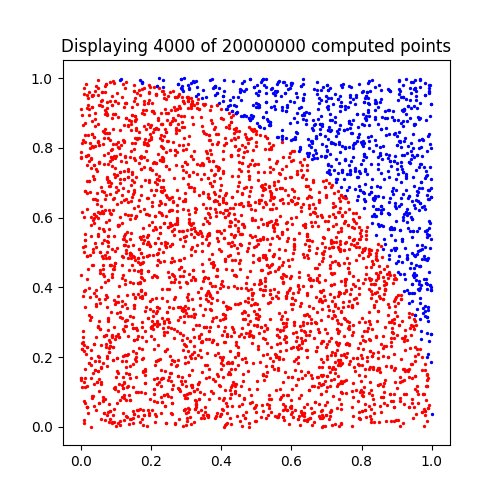

4000
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
Im here


In [47]:
params = pika.URLParameters(rabbitmq_url)
connection = pika.BlockingConnection(params)
channel = connection.channel()
channel.queue_declare(queue=rabbitmq_queue, auto_delete=True)

fig, ax = plt.subplots(figsize=(5,5))
plt.ion()
fig.canvas.draw()
print(((n_functs * n_maps) // iter_send_point) * points_sent_len)
class callback():
    def __init__(self):
        self.n_messages = 0
    
    def __call__(self, ch, method, properties, body):
        l = pickle.loads(body)
        for x, y, z in l:
            color = 'red' if z <= 1 else 'blue'
            ax.scatter(x, y, c=color, s=2)
        self.n_messages += 1
        plt.title("Displaying {} of {} generated points".format(self.n_messages*points_sent_len, n_functs*loop_per_funct*n_maps))
        fig.canvas.draw()
        print(self.n_messages)
        if self.n_messages >= ((n_functs * n_maps) // iter_send_point):
            ch.stop_consuming()

channel.basic_consume(callback(), queue='pi_montecarlo')
channel.start_consuming()
channel.queue_delete(queue=rabbitmq_queue)
connection.close()
plt.close()

In [48]:
results = list()
for fut in futures:
    res = pwex.get_result(futures=fut)
    results.append(res)
est_pi = np.mean(results)
print('Estimated pi: {}'.format(est_pi))
pwex.clean()

ExecutorID c3b2-49cf - Getting results...



Estimated pi: 3.1411759999999997
ExecutorID c3b2-49cf - Cleaning temporary data


ChannelClosed: 